# DeepAR: Multi Time series
- To see if DeepAR is better than LGBM for multi time series forecasting problem
- Although LGBM is easy to be implemented, LGBM
    - cannot leverage exo cat features (holiday, weekday)
    - cannot learn the relationship between exogenous features on the whole time series x[1,w] + y[i]
- This notebook is to demostrate how to handle multi time series (multi horizon) forecasting using nn and find out if nn can overcome the above shortcoming of LGBM

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss, QuantileLoss
from lightning.pytorch.loggers import TensorBoardLogger

from evaluation import Metric, Evaluation
from plotting import Plot, ModelEvaluation
from time_series import TsHandler
from preprocess import Preprocessor, Dataset, Scaler
from multi_horizon import Prediction
from config.get_config import ConfigHandler, HOME_PATH

import warnings
warnings.filterwarnings('ignore')

import random
seed = 42

In [2]:
# Read model_params from notebooks/config/model_params.yml
model_params = ConfigHandler.read_yml("model_params_path")

HORIZON = model_params['common']['horizon']
WINDOWSIZE = HORIZON*3    #model_params['common']['windowsize']

print(f"windowsize:{WINDOWSIZE}")
print(f"horizon:{HORIZON}")
print(f"HOME_PATH:{HOME_PATH}")

windowsize:84
horizon:28
HOME_PATH:D:/jupyter-notebook/Kaggle/m5-forecasting-accuracy/m5-kedro-mlflow


In [3]:
df_sales = pd.read_csv('./data/sales_train_evaluation.csv')
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [4]:
# agg to item lvl for obtaining multi time series with obvious patterns
df = df_sales.drop(columns=[
    'id',
    # 'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
    ])
df_item_id = df.groupby(['item_id']).sum()
df_item_id

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,8,6,11,9,7,7,10,6,5
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,...,15,16,25,9,7,25,19,25,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,5,4,1,3,2,4,2,8,7,5,...,5,7,11,4,8,3,4,5,4,7
HOUSEHOLD_2_513,0,0,0,0,0,0,0,0,0,0,...,4,0,5,3,6,3,0,9,3,4
HOUSEHOLD_2_514,4,8,2,1,1,2,3,8,2,1,...,2,2,2,6,1,0,1,4,3,3


In [5]:
unpivot = pd.melt(
    df_item_id.T.reset_index(drop=True).reset_index().rename(columns={'index': 'time_idx'}),
    id_vars = 'time_idx',
    var_name = 'item_id'
)
unpivot['category'] = unpivot['item_id'].str.split("_").str[0]

unpivot

,time_idx,item_id,value,category
0,0,FOODS_1_001,6,FOODS
1,1,FOODS_1_001,6,FOODS
2,2,FOODS_1_001,4,FOODS
3,3,FOODS_1_001,6,FOODS
4,4,FOODS_1_001,7,FOODS
...,...,...,...,...
5918104,1936,HOUSEHOLD_2_516,1,HOUSEHOLD
5918105,1937,HOUSEHOLD_2_516,1,HOUSEHOLD
5918106,1938,HOUSEHOLD_2_516,3,HOUSEHOLD
5918107,1939,HOUSEHOLD_2_516,4,HOUSEHOLD


In [6]:
# It is important to set "value" from int to float
# Otherwises, KeyError: "Unknown category '923' encountered. Set `add_nan=True` to allow unknown categories"
unpivot = unpivot.astype({"value": "float64"})
unpivot.dtypes

time_idx      int64
item_id      object
value       float64
category     object
dtype: object

## Data Imbalance
- Balanced: FOODS_3_: 252, 555, 714, 694, 226, 377, 080, 099, 804
- Imbalanced: HOUSEHOLD_2_140

In [7]:
names = ['FOODS_3_252', 'FOODS_3_555', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226', 'FOODS_3_377', 'FOODS_3_080', 'FOODS_3_099', 'FOODS_3_804']
names = names + ['HOUSEHOLD_2_140']

unpivot_selected = unpivot[unpivot.item_id.isin(names)]
unpivot_selected

,time_idx,item_id,value,category
1343172,0,FOODS_3_080,210.0,FOODS
1343173,1,FOODS_3_080,145.0,FOODS
1343174,2,FOODS_3_080,137.0,FOODS
1343175,3,FOODS_3_080,100.0,FOODS
1343176,4,FOODS_3_080,143.0,FOODS
...,...,...,...,...
5190229,1936,HOUSEHOLD_2_140,8.0,HOUSEHOLD
5190230,1937,HOUSEHOLD_2_140,11.0,HOUSEHOLD
5190231,1938,HOUSEHOLD_2_140,11.0,HOUSEHOLD
5190232,1939,HOUSEHOLD_2_140,11.0,HOUSEHOLD


In [8]:
unpivot["time_idx"].max()

1940

In [9]:
# create dataset and dataloaders
context_length = WINDOWSIZE
prediction_length = HORIZON
training_cutoff = unpivot_selected["time_idx"].max() - prediction_length

unpivot_training_set = unpivot_selected[unpivot_selected["time_idx"] <= training_cutoff]
# unpivot_valid_set = unpivot[unpivot["time_idx"] > training_cutoff]

train_dataset = TimeSeriesDataSet(
    unpivot_training_set,
    time_idx = "time_idx",
    target = "value",
    group_ids = ["item_id"],
    categorical_encoders = {"category": NaNLabelEncoder(add_nan=True).fit(unpivot_training_set["category"])},
    static_categoricals = ["category"],
    time_varying_unknown_reals = ["value"],
    target_normalizer=GroupNormalizer(groups=["item_id"], transformation="softplus"),
    max_encoder_length = context_length,
    max_prediction_length = prediction_length,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    # static_reals=[ ... ],
    # time_varying_known_categoricals=[ ... ],
    # time_varying_known_reals=[ ... ],
    # time_varying_unknown_categoricals=[ ... ],
    # variable_groups
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, unpivot_selected, min_prediction_idx=training_cutoff + 1)

In [10]:
batch_size = 512
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = train_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = val_dataset.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0,
)

In [11]:
len(train_dataloader)

35

In [12]:
len(val_dataloader)

1

In [13]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.1139, device='cuda:0')

In [14]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1)
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4
)

Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at d:\jupyter-notebook\Kaggle\m5-forecasting-accuracy\m5-kedro-mlflow\notebooks\.lr_find_ea9fd1de-b4c2-46ce-86b5-ab74b2a175cd.ckpt
Restored all states from the checkpoint at d:\jupyter-notebook\Kaggle\m5-forecasting-accuracy\m5-kedro-mlflow\notebooks\.lr_find_ea9fd1de-b4c2-46ce-86b5-ab74b2a175cd.ckpt


suggested learning rate: 0.0014791083881682077


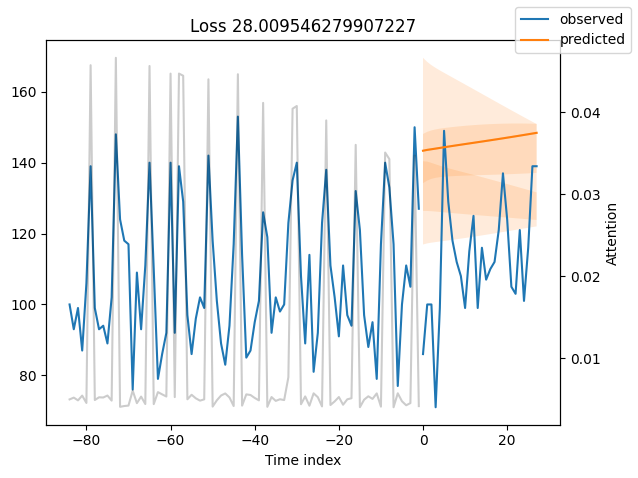

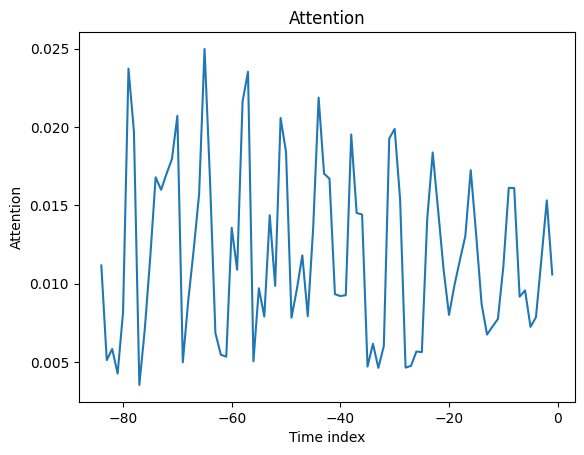

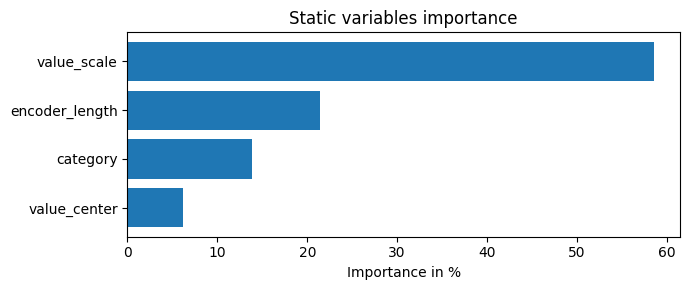

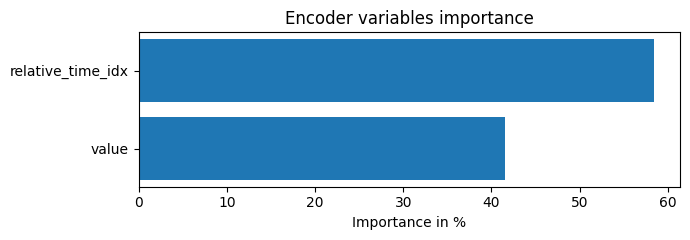

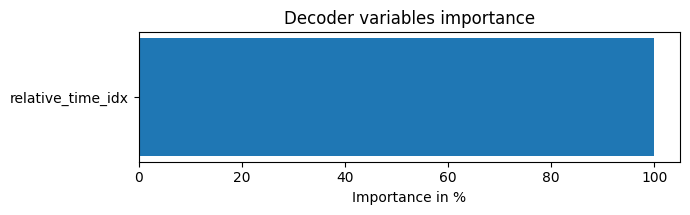

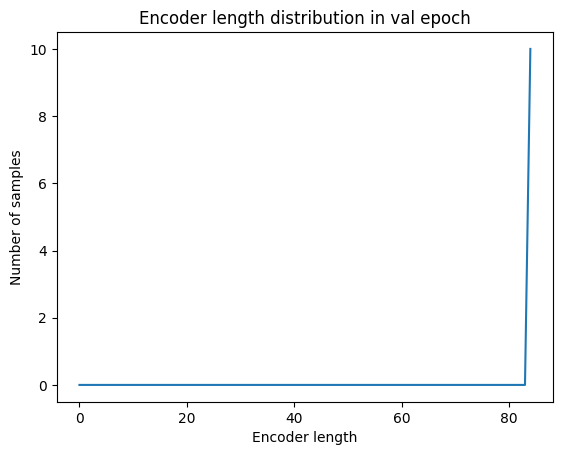

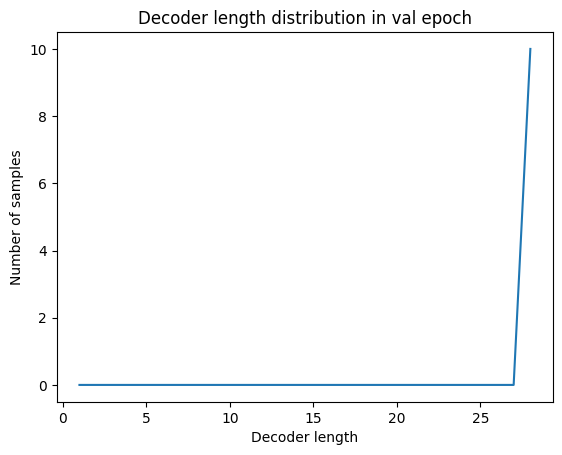

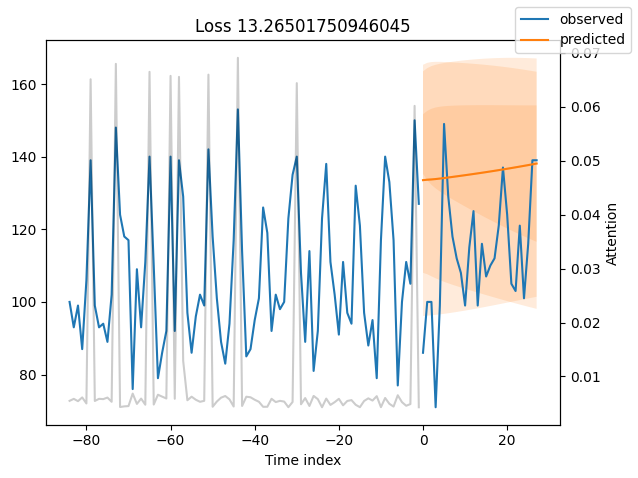

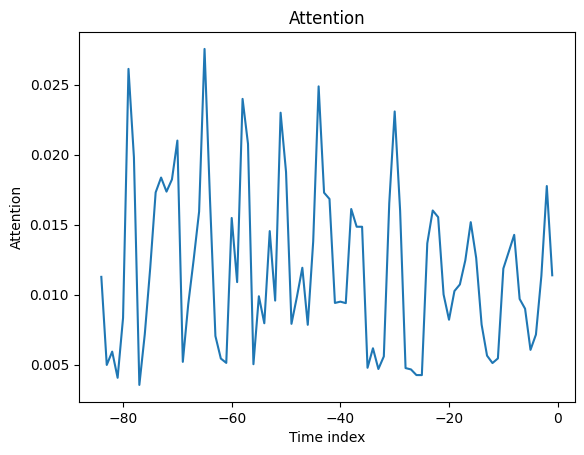

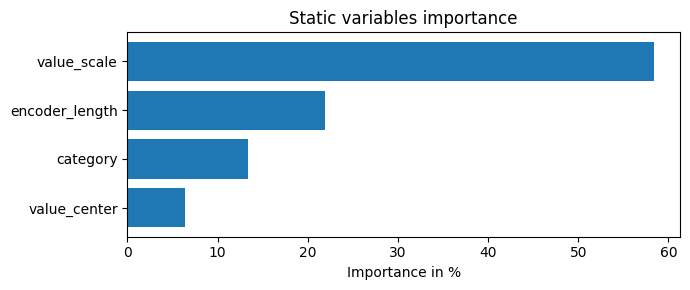

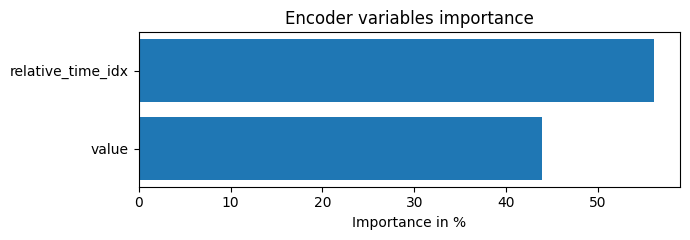

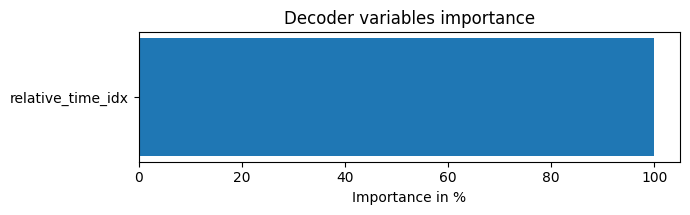

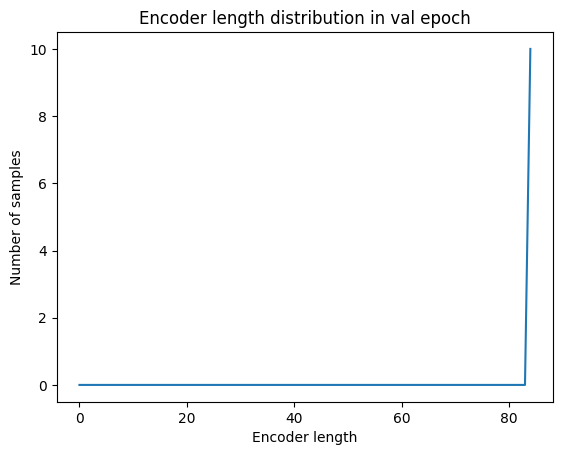

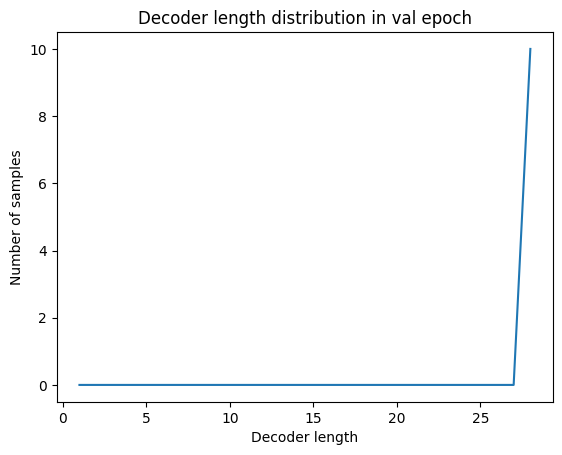

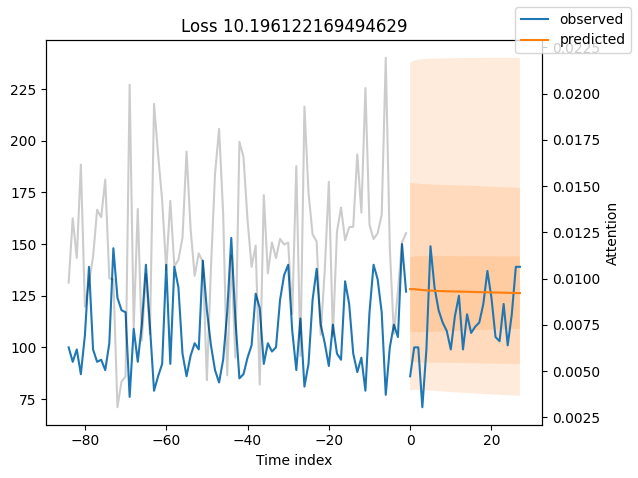

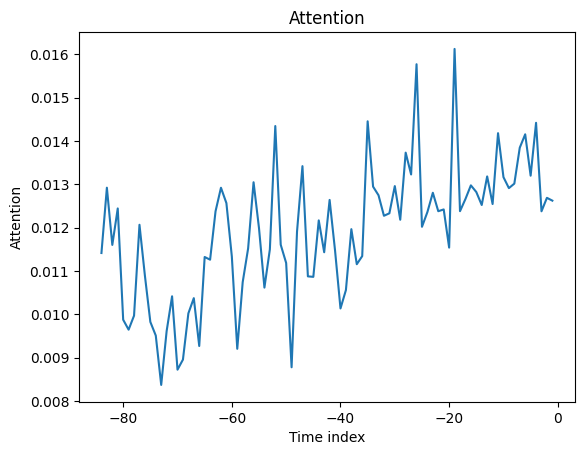

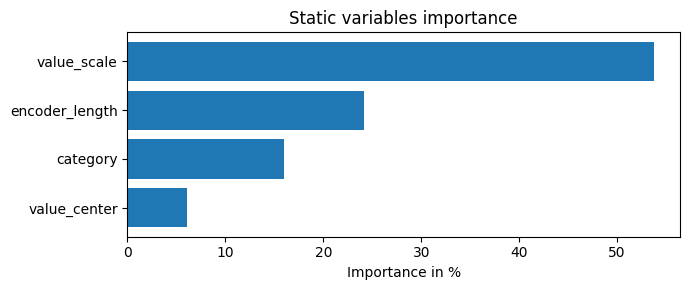

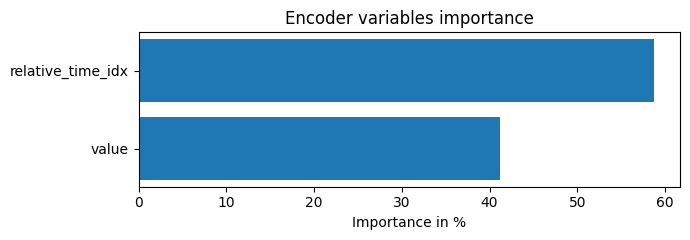

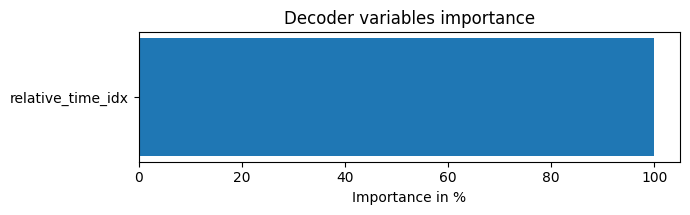

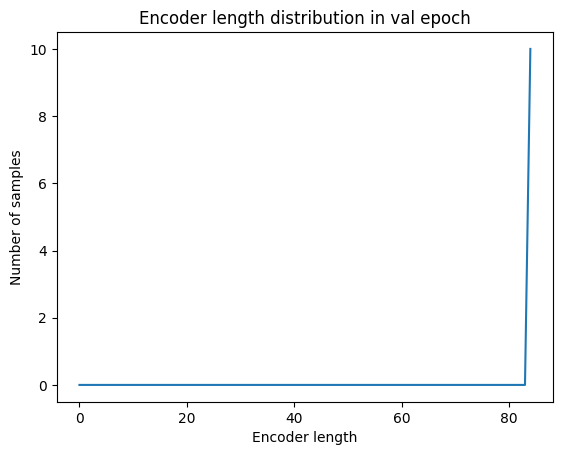

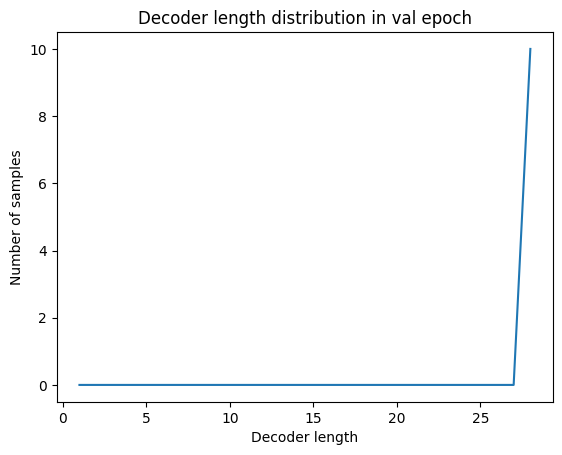

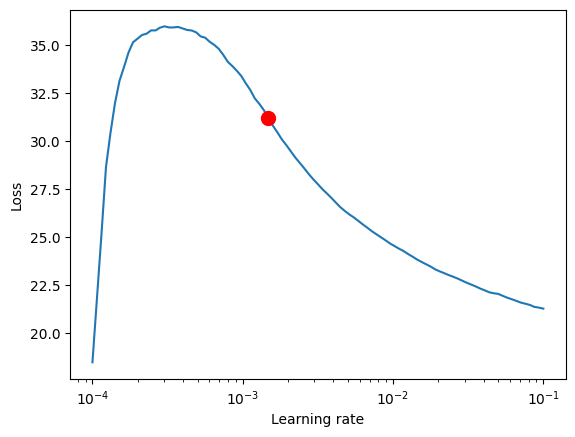

In [15]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-4,
    max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
tft.hparams.learning_rate = res.suggestion()    # 0.0014791083881682077

In [16]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='step', log_momentum=True)
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=200,
    accelerator='gpu', 
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    enable_checkpointing=True,
    default_root_dir=f'{HOME_PATH}/notebooks/saved/model/',
    logger=logger
)

# net.hparams.learning_rate = 0.01

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 9     
3  | prescalers                         | ModuleDict                      | 1.6 K 
4  | static_variabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
trainer.checkpoint_callback.best_model_path

'lightning_logs\\lightning_logs\\version_2\\checkpoints\\epoch=25-step=910.ckpt'

In [18]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [19]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(predictions.output, predictions.y)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.0881, device='cuda:0')

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
predictions = best_model.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))


In [20]:
Metric.smape(predictions.y[0].cpu().numpy(), predictions.output.cpu().numpy())  #0.06630643

0.088105135

In [21]:
raw_predictions = best_model.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="gpu")
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


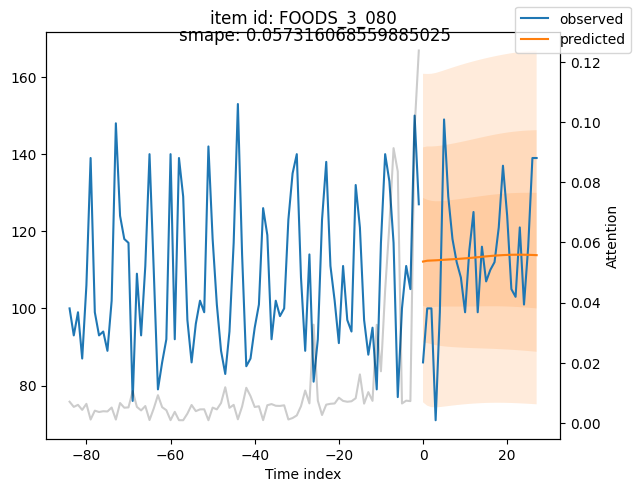

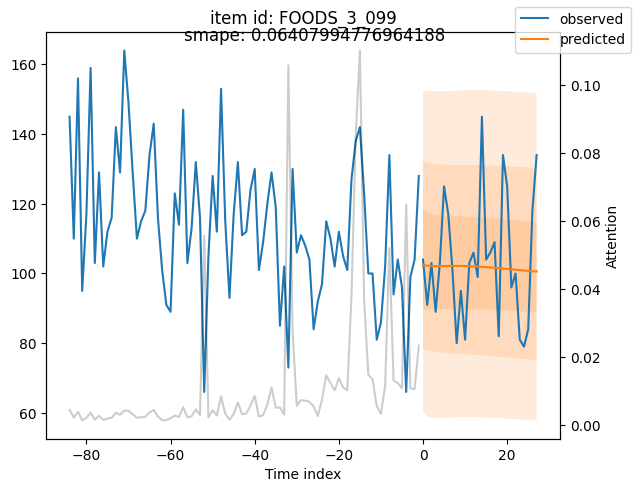

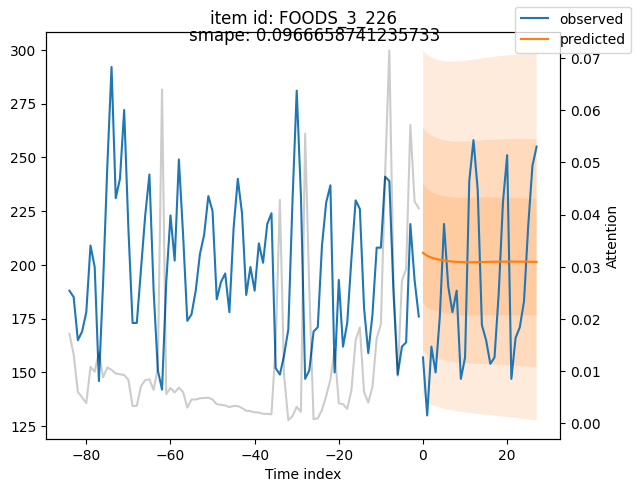

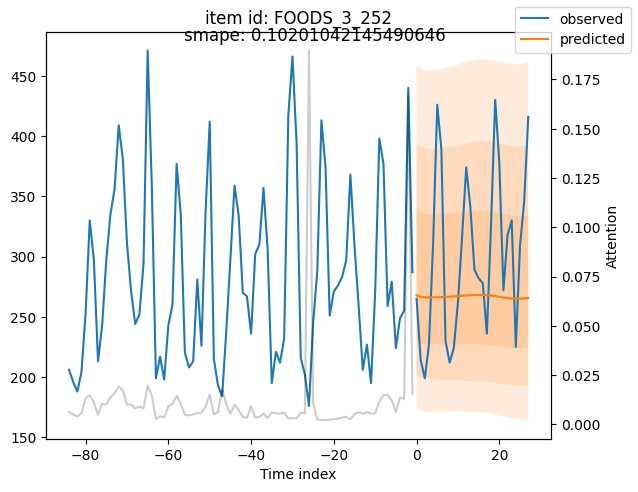

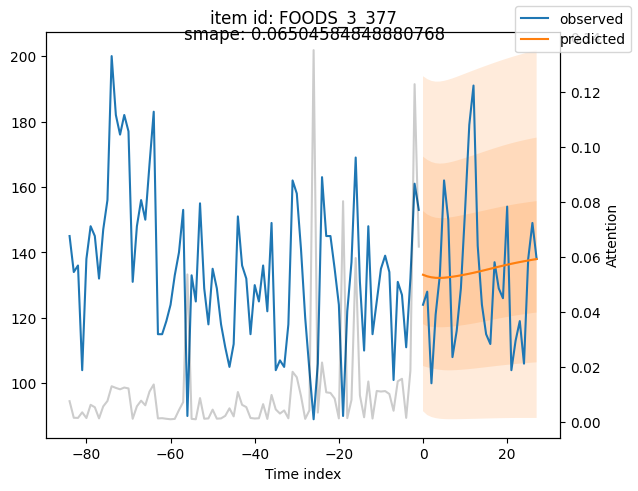

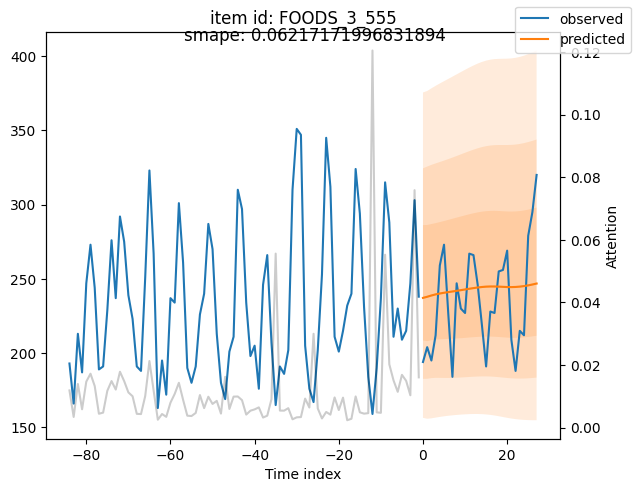

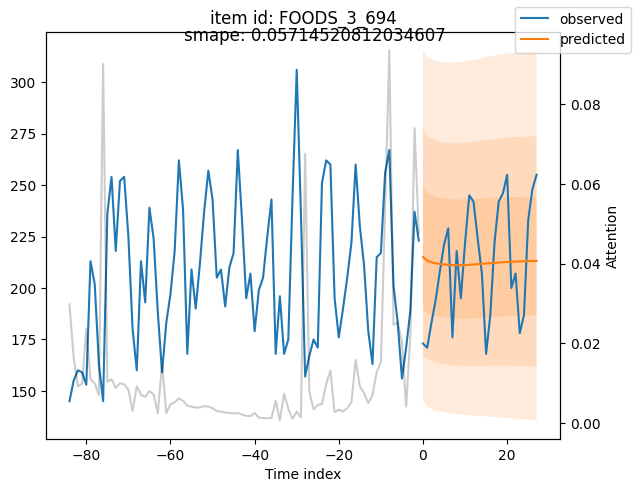

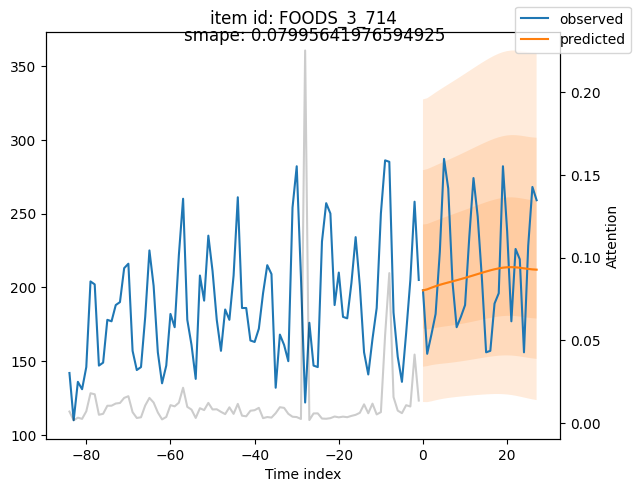

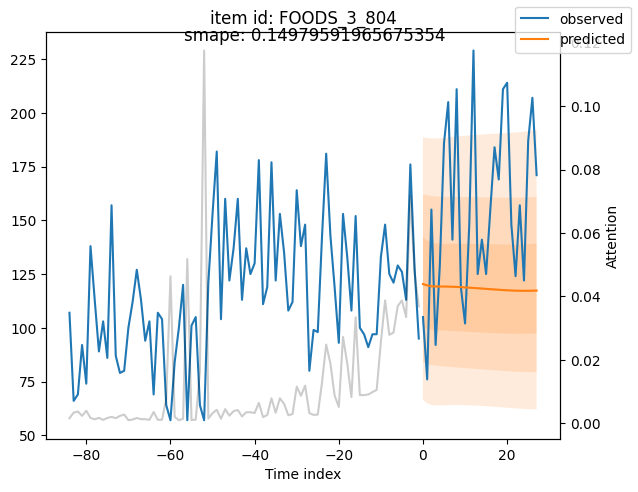

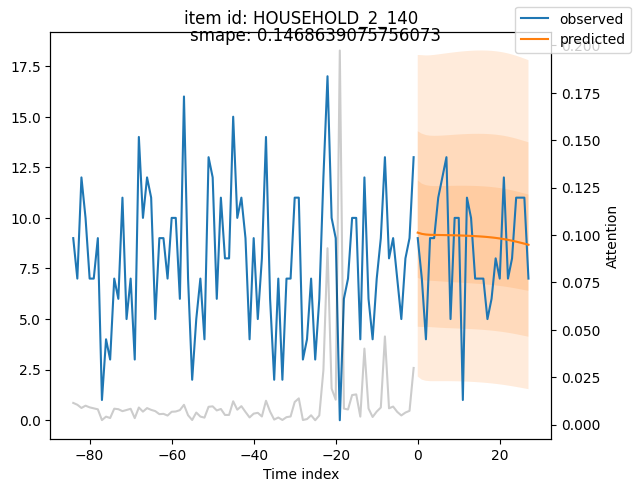

In [22]:
item_id = val_dataset.x_to_index(raw_predictions.x)["item_id"]
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False)
    plt.title(f"item id: {item_id.iloc[idx]}")
    plt.suptitle(f"smape: {Metric.smape(predictions.y[0][idx].cpu().numpy(), predictions.output[idx].cpu().numpy())}")

In [23]:
# cov_matrix = best_model.loss.map_x_to_distribution(
#     best_model.predict(
#         val_dataloader, mode=("raw", "prediction"), n_samples=None, trainer_kwargs=dict(accelerator="cpu")
#     )
# ).base_dist.covariance_matrix.mean(0)

# # normalize the covariance matrix diagnoal to 1.0
# correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(correlation_matrix, cmap="bwr")

# # distribution of off-diagonal correlations
# plt.hist(correlation_matrix[correlation_matrix < 1].numpy())

# Conclusion
- TFT valid smape: 8.81%
- LGBM valid smape: 6.87%